In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/experimental_dataset_tsnv_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5633; Dev set size: 626; Testing set size: 696


In [3]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report

In [4]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/experimental_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

In [5]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    all_preds = np.array(all_preds)[:,:,1].T
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    preds_probs = np.array(preds_probs)[:,:,1].T
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [7]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [8]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")  
    if isinstance(clf, MultiOutputRegressor):
        all_preds = regression_predict(clf, dataset_X)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = np.array(clf.predict_proba(dataset_X)) if not isinstance(clf, MultiOutputRegressor) else regression_predict(clf, dataset_X)
    preds = preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = np.array(clf.predict_proba(dataset_X)) if not isinstance(clf, MultiOutputRegressor) else regression_predict(clf, dataset_X)
    preds = preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, Matern, DotProduct, RationalQuadratic 

gp_clf = MultiOutputRegressor(
    GaussianProcessRegressor(random_state=42), n_jobs=-1
).fit(train_X, train_Y)

gp_clf.score(train_X, train_Y)

1.0

Best Threshold=0.00000, F-Score=0.17758
Best Threshold=0.00000, F-Score=0.11729
Best Threshold=0.00000, F-Score=0.06192
Best Threshold=0.00000, F-Score=0.05891


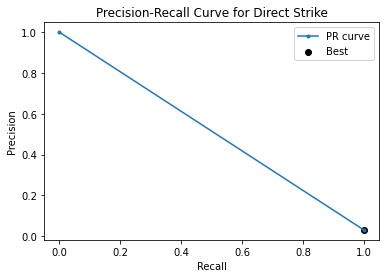

In [12]:
# best_thresholds, best_f1_scores = optimize_thresholds(gp_clf, dev_X, dev_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(gp_clf, dev_X, dev_Y)

In [29]:
preds = predictions_with_thresholds(gp_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        61
           1    0.00000   0.00000   0.00000        39
           2    0.00000   0.00000   0.00000        20
           3    0.00000   0.00000   0.00000        19

   micro avg    0.00000   0.00000   0.00000       139
   macro avg    0.00000   0.00000   0.00000       139
weighted avg    0.00000   0.00000   0.00000       139
 samples avg    0.00000   0.00000   0.00000       139



In [30]:
print(classification_report(dev_Y, gp_clf.predict(dev_X), zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        61
           1    0.00000   0.00000   0.00000        39
           2    0.00000   0.00000   0.00000        20
           3    0.00000   0.00000   0.00000        19

   micro avg    0.00000   0.00000   0.00000       139
   macro avg    0.00000   0.00000   0.00000       139
weighted avg    0.00000   0.00000   0.00000       139
 samples avg    0.00000   0.00000   0.00000       139



In [13]:
gp_clf.predict(dev_X)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])